In [80]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Question 1

## Data Preparation

In [3]:
outpatient = pd.read_csv('./VTOUTP16.TXT')

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (2,5,54,55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
ra = pd.read_csv('RA.csv')
other_ra = pd.read_csv('Other_RA.csv')

## Step 1: Identify the RA cohort using the outpatient file. 

In [5]:
ra_outpatient = pd.DataFrame()
for i in range(20):
    temp = outpatient.merge(ra['ICD-10 Codes'], left_on= f'DX{i+1}', right_on='ICD-10 Codes')
    ra_outpatient = pd.concat([ra_outpatient, temp])

In [6]:
other_ra_outpatient = pd.DataFrame()
for i in range(20):
    temp = outpatient.merge(other_ra['ICD-10 Codes'], left_on= f'DX{i+1}', right_on='ICD-10 Codes')
    other_ra_outpatient = pd.concat([other_ra_outpatient, temp])

In [7]:
print(ra_outpatient.shape)
ra_outpatient.drop_duplicates(subset='Uniq').shape
# 981 Diagnoses  976 patients

(981, 71)


(976, 71)

In [8]:
print(other_ra_outpatient.shape)
other_ra_outpatient.drop_duplicates(subset='Uniq').shape
# 31 diagnoses 30 patients

(31, 71)


(30, 71)

## Step 2: Identify the most common types of the RA

In [9]:
ra_outpatient_freq = ra_outpatient.groupby('ICD-10 Codes')['Uniq'].count()
ra_outpatient_freq.sort_values(ascending=False)
# Top 3 M069. M0579, M059

ICD-10 Codes
M069      909
M0579      17
M059        8
M0600       6
M0609       4
M06871      4
M06072      3
M0570       2
M06342      2
M06341      2
M06322      2
M0689       2
M06071      2
M0680       2
M06851      2
M06861      2
M06872      1
M05741      1
M05742      1
M05761      1
M05762      1
M06832      1
M05812      1
M06031      1
M06051      1
M06842      1
M06331      1
M06041      1
Name: Uniq, dtype: int64

In [10]:
other_ra_outpatient_freq = other_ra_outpatient.groupby('ICD-10 Codes')['Uniq'].count()
other_ra_outpatient_freq.sort_values(ascending=False)
# Top 3 M510, M05671, M0519

ICD-10 Codes
M0510     21
M05671     2
M0519      2
M061       1
M05672     1
M0560      1
M05142     1
M05141     1
M0500      1
Name: Uniq, dtype: int64

## Step 3: Gender differences in RA

In [11]:
ra_outpatient['is_RA'] = 1
outpatient_new = outpatient.merge(ra_outpatient[['Uniq', 'is_RA']].drop_duplicates(subset='Uniq'), how='left').fillna(0)

In [12]:
other_ra_outpatient['is_other_RA'] = 1
outpatient_new = outpatient_new.merge(other_ra_outpatient[['Uniq', 'is_other_RA']].drop_duplicates(subset='Uniq'), how='left').fillna(0)

In [13]:
outpatient_new.sex.replace(' ', np.nan, inplace=True)

In [14]:
outpatient_new.dropna(subset=['sex', 'is_RA', 'is_other_RA'], inplace=True)

In [15]:
outpatient_new.sex = outpatient_new.sex.astype(int)
outpatient_new.is_RA = outpatient_new.is_RA.astype(int)
outpatient_new.is_other_RA = outpatient_new.is_other_RA.astype(int)

### Gender bias in RA

In [16]:
ra_xtab = outpatient_new.groupby(['sex', 'is_RA'])['Uniq'].count().unstack()
oddsratio, pvalue = stats.fisher_exact(ra_xtab)
print('Odds ratio:', oddsratio)
print('p-value: ', pvalue)

Odds ratio: 2.3975543884127677
p-value:  1.4457910557520762e-36


In [17]:
ra_xtab

is_RA,0,1
sex,,
1,168150,252
2,201496,724


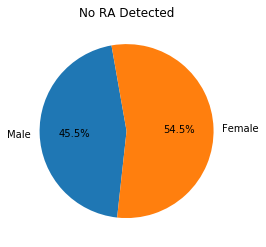

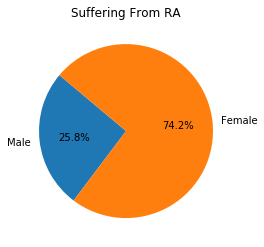

In [18]:
fig, ax = plt.subplots()
ax.pie(ra_xtab[0], labels=['Male', 'Female'], startangle=100, autopct='%1.1f%%')
ax.set_title('No RA Detected')
plt.savefig('No RA Detected.png')
plt.show()

fig, ax = plt.subplots()
ax.pie(ra_xtab[1], labels=['Male', 'Female'], startangle=140, autopct='%1.1f%%')
ax.set_title('Suffering From RA')
plt.savefig('Suffering From RA.png')
plt.show()

### Gender bias in other_RA

In [19]:
other_ra_xtab = outpatient_new.groupby(['sex', 'is_other_RA'])['Uniq'].count().unstack()
oddsratio, pvalue = stats.fisher_exact(other_ra_xtab)
print('Odds ratio:', oddsratio)
print('p-value: ', pvalue)

Odds ratio: 0.9517290883040325
p-value:  1.0


In [20]:
other_ra_xtab

is_other_RA,0,1
sex,,
1,168388,14
2,202204,16


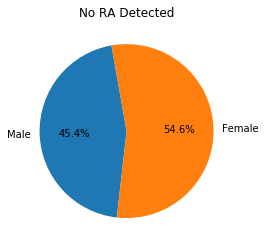

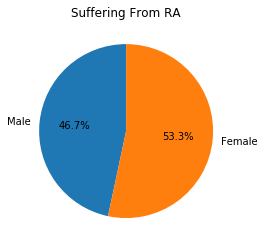

In [21]:
fig, ax = plt.subplots()
ax.pie(other_ra_xtab[0], labels=['Male', 'Female'], startangle=100, autopct='%1.1f%%')
ax.set_title('No RA Detected')
plt.savefig('No other RA Detected.png')
plt.show()

fig, ax = plt.subplots()
ax.pie(other_ra_xtab[1], labels=['Male', 'Female'], startangle=90, autopct='%1.1f%%')
ax.set_title('Suffering From RA')
plt.savefig('Suffering From other RA.png')
plt.show()

## Step 4: Calculate the inter-quartile range of the costs

In [22]:
outpatient.CHRGS.describe()

count    370633.000000
mean       3087.405855
std        4915.324061
min           0.000000
25%         682.480000
50%        1521.620000
75%        3440.180000
max      227311.780000
Name: CHRGS, dtype: float64

In [23]:
stats.iqr(outpatient.CHRGS)

2757.7

## Step 5: Study of service utilization

In [24]:
revcode = pd.read_csv('VTREVCODE16.TXT')

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (6,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
revcode_ra = revcode.merge(ra_outpatient.drop_duplicates(subset='Uniq')['Uniq'])

In [26]:
revcode_other_ra = revcode.merge(other_ra_outpatient.drop_duplicates(subset='Uniq')['Uniq'])

In [27]:
revcode_ra.groupby('REVCODE')['Uniq'].count().sort_values(ascending=False)
# TOP 5 Services 300, 636, 250, 450, 320

REVCODE
300    3219
636    1218
250    1161
450    1055
320     373
259     286
730     280
270     234
360     229
370     219
710     215
260     199
272     194
762     163
301     155
420     153
258     153
310     139
361     111
637     105
510      82
351      78
460      75
761      74
278      73
352      70
305      69
350      62
324      48
490      41
       ... 
307      10
434       9
610       8
920       7
255       6
480       6
612       6
341       5
390       5
335       4
311       4
309       4
481       4
731       4
444       3
401       2
292       2
312       2
391       2
615       2
623       2
280       1
279       1
275       1
359       1
619       1
681       1
740       1
790       1
942       1
Name: Uniq, Length: 81, dtype: int64

In [28]:
revcode_other_ra.groupby('REVCODE')['Uniq'].count().sort_values(ascending=False)
# TOP 5 Services 300, 460, 510, 636, 259

REVCODE
300    53
460    47
510    18
636    12
259    10
450    10
250     7
301     6
730     5
258     4
420     4
260     4
270     4
320     4
710     3
370     3
360     3
762     3
255     2
305     2
352     2
310     2
324     2
424     2
430     2
272     1
351     1
361     1
483     1
771     1
Name: Uniq, dtype: int64

# Question 3

## Data Preparation

In [29]:
inpatient = pd.read_csv('VTINP16_upd.csv')
revcode = pd.read_csv('VTREVCODE16.TXT')

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (2,5,8,54,55,73,74,75,76,78) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
drg_code = pd.read_csv('DRG_CODE.csv')
pccr_code = pd.read_csv('PCCR_CODE.csv')

In [31]:
inpatient.DRG = inpatient.DRG.replace(' ', np.nan)
inpatient.dropna(subset=['DRG'], inplace=True)
inpatient.DRG = inpatient.DRG.astype(int)

In [32]:
# Filter only important DRGs 
inpatient = inpatient[(inpatient.DRG<=977)&(inpatient.DRG>=20)&(inpatient.DRG.isin(drg_code.MSDRG))]

In [33]:
revcode.PCCR = revcode.PCCR.replace(' ', np.nan)
revcode.dropna(subset=['PCCR'], inplace=True)
revcode.PCCR = revcode.PCCR.astype(int)

In [34]:
# Exclude the low dollar value services
revcode.REVCHRGS = revcode.REVCHRGS.replace(' ', np.nan).astype(float)
revcode_big = revcode[(revcode.REVCHRGS>=100)&(revcode.PCCR.isin(pccr_code.PCCR))]

In [35]:
# Merge revcode and inpatient data
re_inpatient = inpatient.merge(revcode_big, how='inner', left_on='UNIQ', right_on='Uniq')

In [36]:
# Generate the cross tabulated file
re_inpatient.REVCHRGS = re_inpatient.REVCHRGS.astype(float)
charge_pccr = re_inpatient.groupby(['UNIQ', 'DRG', 'PCCR'])['REVCHRGS'].sum()
charge_temp = charge_pccr.unstack()
charge_temp = charge_temp.reset_index()
cross_table = charge_temp.groupby('DRG').mean().drop('UNIQ', axis=1)

In [37]:
# Combine PCCR 3700 & 4000
cross_table['PCCR_OR_and_Anesth_Costs'] = cross_table.loc[:, 3700].fillna(0) + cross_table.loc[:, 4000].fillna(0)

In [38]:
# Reset index and columns names
pccr_code_name = pccr_code.iloc[:, :2].set_index('PCCR').to_dict()
drg_code_name = drg_code.iloc[:, [0,2]].set_index('MSDRG').to_dict()
cross_table_new = cross_table.rename(columns=pccr_code_name['PCCR_NAME'], index=drg_code_name['MSDRG_DESC'])

In [39]:
# Turn N/A value to 0 
cross_table_new.fillna(0, inplace=True)

## K-clustering

In [40]:
data_train = cross_table_new['PCCR_OR_and_Anesth_Costs'].to_numpy().reshape(-1, 1)

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

In [42]:
# k=2
model = KMeans(n_clusters=2, random_state=0).fit(data_train)
clusters = model.predict(data_train)
calinski_harabasz_score(data_train, clusters)

1429.752223359702

In [43]:
# k=3
model = KMeans(n_clusters=3, random_state=0).fit(data_train)
clusters_3 = model.predict(data_train)
calinski_harabasz_score(data_train, clusters_3)

1725.8096202802003

In [44]:
# k=4
model = KMeans(n_clusters=4, random_state=0).fit(data_train)
clusters = model.predict(data_train)
calinski_harabasz_score(data_train, clusters)

1978.0241807560121

In [45]:
# k=5
model = KMeans(n_clusters=5, random_state=0).fit(data_train)
clusters = model.predict(data_train)
calinski_harabasz_score(data_train, clusters)

2191.6102198382987

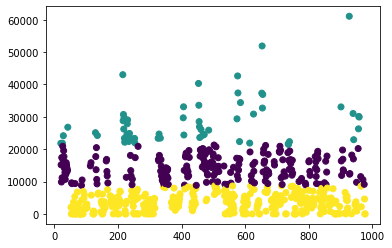

In [46]:
fig, ax = plt.subplots()
ax.scatter(cross_table.index, cross_table_new['PCCR_OR_and_Anesth_Costs'], c=clusters_3)
plt.show()

## Interpretion

In [47]:
cluster_result = pd.DataFrame()
cluster_result['PCCR_OR_and_Anesth_Costs'] = cross_table['PCCR_OR_and_Anesth_Costs']
cluster_result['cluster'] = clusters_3
cluster_result['DRG_name'] = cross_table_new.index

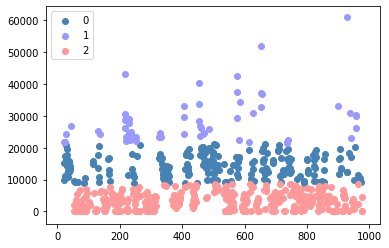

In [48]:
fig, ax = plt.subplots()
colors = ['steelblue', '#9999ff', '#ff9999']
for i in range(3):
    temp = cluster_result[cluster_result['cluster']==i]
    ax.scatter(temp.index, temp['PCCR_OR_and_Anesth_Costs'], c=colors[i], label=i)
ax.legend()
plt.show()

In [49]:
re_inpatient_cluster = re_inpatient[(re_inpatient.PCCR==3700)|(re_inpatient.PCCR==4000)]

In [68]:
cluster_result.to_csv('cluster_results_Henry.csv', index=None)

### REVCODE Difference

In [72]:
cluster_result = cluster_result.reset_index()
re_inpatient_cluster = re_inpatient_cluster.merge(cluster_result,how='inner')
re_inpatient_cluster.loc[re_inpatient_cluster.cluster==0, 'cluster_name'] = 'Rare'
re_inpatient_cluster.loc[re_inpatient_cluster.cluster==1, 'cluster_name'] = 'Extreme'
re_inpatient_cluster.loc[re_inpatient_cluster.cluster==2, 'cluster_name'] = 'Common'
cluster_service = re_inpatient_cluster.groupby(['cluster', 'cluster_name', 'REVCODE'])['Uniq'].count()
cluster_service = cluster_service.reset_index()

In [73]:
cluster_service

,cluster,cluster_name,REVCODE,Uniq
0,0,Rare,360,8048
1,0,Rare,361,1108
2,0,Rare,369,21
3,0,Rare,370,7739
4,0,Rare,379,3
5,1,Extreme,360,1111
6,1,Extreme,361,251
7,1,Extreme,370,1115
8,2,Common,360,2397
9,2,Common,361,2546


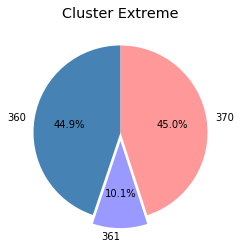

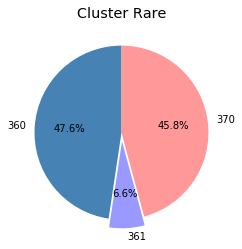

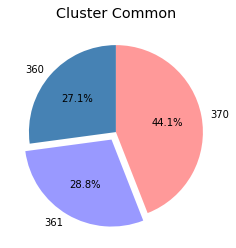

In [74]:
for i in [1, 0 ,2]:
    temp = cluster_service[(cluster_service.cluster==i)&(cluster_service.REVCODE.isin([360, 361, 370]))]
    temp = temp.sort_values('REVCODE')
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    ax.pie(temp['Uniq'], labels=temp['REVCODE'], explode=[0, 0.1, 0], startangle=90, autopct='%1.1f%%', colors=['steelblue', '#9999ff', '#ff9999'])
    ax.set_title(f'Cluster {temp.loc[:, "cluster_name"].unique()[0]}')
    plt.savefig(f'Cluster {temp.loc[:, "cluster_name"].unique()[0]}.png')
    plt.show()
# 360: Operating Room Services
# 361: Operating Room Services: Minor surgery
# 370: Anesthesia

### Secure days and Pdays

In [101]:
import scipy.stats as stats

In [86]:
re_inpatient_cluster.SCUD = re_inpatient_cluster.SCUD.replace(' ', np.nan).astype(float).fillna(0)

In [103]:
stats.ttest_ind(re_inpatient_cluster.loc[re_inpatient_cluster.cluster_name=='Extreme', 'SCUD'], 
                re_inpatient_cluster.loc[re_inpatient_cluster.cluster_name=='Rare', 'SCUD'])
# difference between 'Extreme' and 'Rare' is significant

Ttest_indResult(statistic=2.855652644166643, pvalue=0.004299406509624691)

In [106]:
stats.ttest_ind(re_inpatient_cluster.loc[re_inpatient_cluster.cluster_name=='Common', 'SCUD'], 
                re_inpatient_cluster.loc[re_inpatient_cluster.cluster_name=='Rare', 'SCUD'])

Ttest_indResult(statistic=1.140789692584026, pvalue=0.2539680585502103)

In [87]:
scu_cluster = re_inpatient_cluster.groupby(['cluster_name'])['SCUD'].mean()[['Extreme', 'Rare', 'Common']]

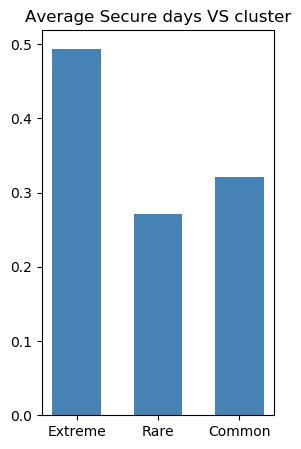

In [98]:
plt.style.use('default')
fig, ax = plt.subplots()
ax.bar(scu_cluster.index, scu_cluster, color='steelblue', width=0.6)
plt.grid(False)
ax.set_title('Average Secure days VS cluster')
fig.set_size_inches([3,5])
plt.savefig('scu_day.png')
plt.show()

In [93]:
re_inpatient_cluster.pdays = re_inpatient_cluster.pdays.replace(' ', np.nan).astype(float).fillna(0)

In [104]:
stats.ttest_ind(re_inpatient_cluster.loc[re_inpatient_cluster.cluster_name=='Extreme', 'pdays'], 
                re_inpatient_cluster.loc[re_inpatient_cluster.cluster_name=='Rare', 'pdays'])
# difference between 'Extreme' and 'Rare' is significant

Ttest_indResult(statistic=30.652038255301413, pvalue=1.5596623370145302e-201)

In [107]:
stats.ttest_ind(re_inpatient_cluster.loc[re_inpatient_cluster.cluster_name=='Common', 'pdays'], 
                re_inpatient_cluster.loc[re_inpatient_cluster.cluster_name=='Rare', 'pdays'])

Ttest_indResult(statistic=7.987174744425065, pvalue=1.4379696053460577e-15)

In [94]:
pday_cluster = re_inpatient_cluster.groupby(['cluster_name'])['pdays'].mean()[['Extreme', 'Rare', 'Common']]

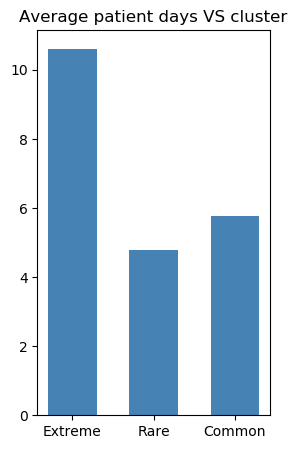

In [100]:
fig, ax = plt.subplots()
ax.bar(pday_cluster.index, pday_cluster, color='steelblue', width=0.6)
ax.set_title('Average patient days VS cluster')
fig.set_size_inches([3,5])
plt.savefig('pday.png')
plt.show()